In [71]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# Create SQLite in-memory database
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

In [73]:
df = pd.read_csv("train.csv")

In [74]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [75]:
df["Order Date"] = pd.to_datetime(df["Order Date"], dayfirst=True)
df["Ship Date"] = pd.to_datetime(df["Ship Date"], dayfirst=True)

In [76]:
# Load into SQLite
df.to_sql("sales_raw", conn, if_exists="replace", index=False)

# Check first 5 rows from SQL
print(pd.read_sql_query("SELECT * FROM sales_raw LIMIT 5;", conn))

   Row ID        Order ID           Order Date            Ship Date  \
0       1  CA-2017-152156  2017-11-08 00:00:00  2017-11-11 00:00:00   
1       2  CA-2017-152156  2017-11-08 00:00:00  2017-11-11 00:00:00   
2       3  CA-2017-138688  2017-06-12 00:00:00  2017-06-16 00:00:00   
3       4  US-2016-108966  2016-10-11 00:00:00  2016-10-18 00:00:00   
4       5  US-2016-108966  2016-10-11 00:00:00  2016-10-18 00:00:00   

        Ship Mode Customer ID    Customer Name    Segment        Country  \
0    Second Class    CG-12520      Claire Gute   Consumer  United States   
1    Second Class    CG-12520      Claire Gute   Consumer  United States   
2    Second Class    DV-13045  Darrin Van Huff  Corporate  United States   
3  Standard Class    SO-20335   Sean O'Donnell   Consumer  United States   
4  Standard Class    SO-20335   Sean O'Donnell   Consumer  United States   

              City       State  Postal Code Region       Product ID  \
0        Henderson    Kentucky      42420.0  

In [77]:
# STEP 6: CREATE STAGING TABLE WITH CLEANED COLUMNS
conn.execute("""
CREATE TABLE sales_stage AS
SELECT 
    "Row ID" AS row_id,
    "Order ID" AS order_id,
    date("Order Date") AS order_date,
    date("Ship Date") AS ship_date,
    TRIM("Ship Mode") AS ship_mode,
    "Customer ID" AS customer_id,
    TRIM("Customer Name") AS customer_name,
    TRIM(Segment) AS segment,
    TRIM(Country) AS country,
    TRIM(City) AS city,
    TRIM(State) AS state,
    "Postal Code" AS postal_code,
    TRIM(Region) AS region,
    "Product ID" AS product_id,
    TRIM(Category) AS category,
    TRIM("Sub-Category") AS sub_category,
    TRIM("Product Name") AS product_name,
    CAST(Sales AS REAL) AS sales
FROM sales_raw
""")

# STEP 7: REMOVE DUPLICATES
conn.execute("""
DELETE FROM sales_stage
WHERE row_id NOT IN (
    SELECT MIN(row_id)
    FROM sales_stage
    GROUP BY order_id, product_id
)
""")
conn.commit()

# STEP 8: CREATE FINAL CLEAN TABLE WITH EXTRA CALCULATIONS
conn.execute("""
CREATE TABLE sales_clean AS
SELECT *,
       strftime('%Y-%m', order_date) AS order_month
FROM sales_stage
""")
conn.commit()

# STEP 9: SQL AGGREGATIONS → PANDAS → PLOTS

# 9.1 Sales by Region
sales_by_region = pd.read_sql_query("""
SELECT region, ROUND(SUM(sales), 2) AS total_sales
FROM sales_clean
GROUP BY region
ORDER BY total_sales DESC
""", conn)

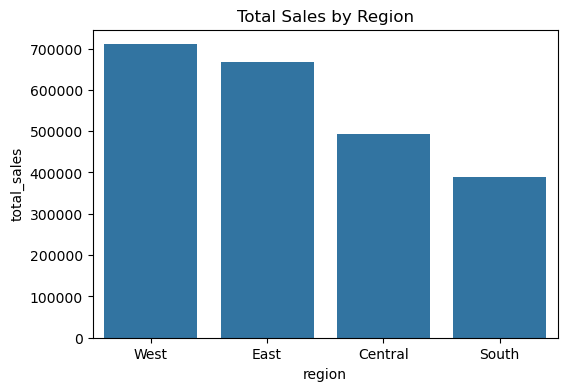

In [78]:
plt.figure(figsize=(6,4))
sns.barplot(data=sales_by_region, x="region", y="total_sales")
plt.title("Total Sales by Region")
plt.show()

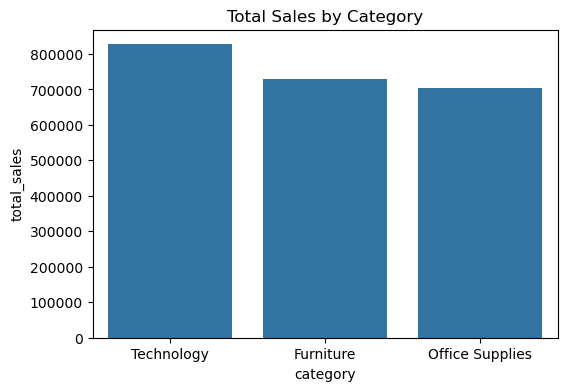

In [79]:
# 9.2 Top Categories
top_categories = pd.read_sql_query("""
SELECT category, ROUND(SUM(sales), 2) AS total_sales
FROM sales_clean
GROUP BY category
ORDER BY total_sales DESC
""", conn)

plt.figure(figsize=(6,4))
sns.barplot(data=top_categories, x="category", y="total_sales")
plt.title("Total Sales by Category")
plt.show()

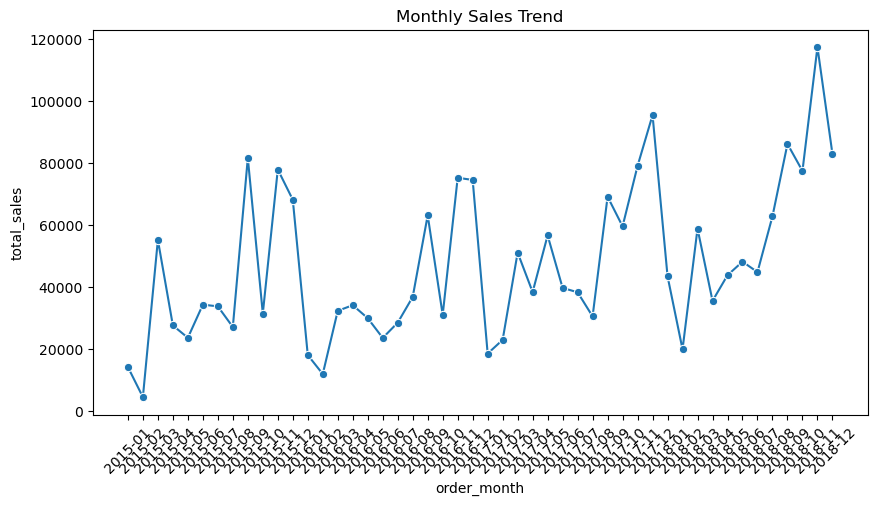

In [80]:
# 9.3 Monthly Sales Trend
monthly_sales = pd.read_sql_query("""
SELECT order_month, ROUND(SUM(sales), 2) AS total_sales
FROM sales_clean
GROUP BY order_month
ORDER BY order_month
""", conn)

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_sales, x="order_month", y="total_sales", marker="o")
plt.title("Monthly Sales Trend")
plt.xticks(rotation=45)
plt.show()

In [81]:
# STEP 10: EXPORT CLEANED DATA
sales_clean_df = pd.read_sql_query("SELECT * FROM sales_clean", conn)
sales_clean_df.to_csv("sales_clean.csv", index=False)

conn.close()